# Imports, install and mount

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# my_local_drive='/content/gdrive/MyDrive/SL2024/datas'
# # Ajout du path pour les librairies, fonctions et données
# sys.path.append(my_local_drive)
# # Se positionner sur le répertoire associé
# %cd $my_local_drive
# # %pwd
# print("DRIVE MOUNTED")

<!--  -->

In [2]:
# ! pip install cuda
# ! pip install torch_geometric
# ! pip install nxontology
# ! pip install tensordict
# ! pip install pandas
# ! pip install tensorflow
# ! pip install scipy
# ! pip install matplotlib

import random
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os.path as osp
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
import pandas as pd
from tqdm import tqdm
from torch_geometric.loader import DataLoader

from torch.nn.functional import normalize
from tensordict.tensordict import TensorDict
import torch.nn.functional as F

from nxontology.imports import from_file


# Settings


In [3]:
# ComplEx embeddings :

hidden_channels = 10
batch_size = 4096
epochs = 1000
# file_path = '/content/gdrive/MyDrive/SL2024/datas/genes_to_phenotypes_iric.tsv'
# file_path = r"C:\Users\Admin\Desktop\Stage_LIRMM_2024\ESL2024\DATAS\little_Os_GO_iric.tsv"
file_path = "/home/elliot/Documents/ESL2024/data/little_genes_to_phenotypes_iric.tsv"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu' # Tip : Use cpu for debugging
print(device)


# Losses tests :

n_negative_triplets_per_positive = 4 # Number of false negatives triples per positive triple in the dataset for losses tests.
url = "https://purl.obolibrary.org/obo/go/go-basic.json.gz" # Where should I look for GO ?

cpu


# Preparing ComplEx embeddings

## TSV to pyg.Data

We want :
- x (tensorised and processed node attributes) (1 for now)
- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
- edge_attr (a tensor that indicate the type of each edge)
- y (edge labels - optional, can be defined as node labels if needed)

## Reading and mapping graph

What we want : Create a Data object with all the properties I want to use later

	- x (tensorised and processed node attributes) (Not for now)
	- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
	- y (desired edge labels - optional, can be defined as node labels if needed) (Not for now)
	- any other things you want to use later

In [4]:
iric = pd.read_csv(file_path, delimiter='\t', names = ['subject', 'predicate','object'])
display(iric)

# Mapping entities to ids

entity_set = set(iric['object']).union(set(iric['subject']))
entity_to_mapping = {entity: int(i) for i, entity in enumerate(entity_set)}
relation_set = set(iric['predicate'])
relation_to_mapping = {relation: int(i) for i, relation in enumerate(relation_set)}

mapped_iric = iric.copy()
mapped_iric['object'] = mapped_iric['object'].apply(lambda x: entity_to_mapping[x])
mapped_iric['subject'] = mapped_iric['subject'].apply(lambda x: entity_to_mapping[x])
mapped_iric['predicate'] = mapped_iric['predicate'].apply(lambda x: relation_to_mapping[x])

display(mapped_iric)

print('OK')
print("Minima in mappings :")
print('subject :', min(mapped_iric['subject']))
print('predicate :',min(mapped_iric['predicate']))
print('object :',min(mapped_iric['object']))

print(entity_to_mapping)
print(relation_to_mapping)

mapping_to_entity = {v: k for k, v in entity_to_mapping.items()}
mapping_to_relation = {v: k for k, v in relation_to_mapping.items()}

print("Mapping to entity dict :",mapping_to_entity)
print("Mapping to relation dict",mapping_to_relation)

,subject,predicate,object
0,OsNippo01g010050,gene ontology,GO:0031267
1,OsNippo01g010050,gene ontology,GO:0006886
2,OsNippo01g010050,gene ontology,GO:0005622
3,OsNippo01g010050,gene ontology,GO:0005623
4,OsNippo01g010050,gene ontology,GO:0090630
...,...,...,...
9996,OsNippo01g223000,gene ontology,GO:0005784
9997,OsNippo01g223050,gene ontology,GO:0005634
9998,OsNippo01g223050,gene ontology,GO:0005737
9999,OsNippo01g223050,gene ontology,GO:0003676


,subject,predicate,object
0,2261,0,1892
1,2261,0,1115
2,2261,0,2278
3,2261,0,3187
4,2261,0,1786
...,...,...,...
9996,3052,0,3089
9997,2203,0,487
9998,2203,0,268
9999,2203,0,732


OK
Minima in mappings :
subject : 1
predicate : 0
object : 0
{'GO:0051233': 0, 'OsNippo01g044650': 1, 'OsNippo01g073000': 2, 'OsNippo01g214700': 3, 'GO:0033320': 4, 'GO:0042026': 5, 'GO:0002183': 6, 'GO:0006420': 7, 'GO:0000373': 8, 'OsNippo01g086950': 9, 'GO:0046564': 10, 'OsNippo01g029750': 11, 'GO:0003735': 12, 'OsNippo01g184950': 13, 'OsNippo01g052450': 14, 'GO:0071633': 15, 'OsNippo01g016400': 16, 'GO:0015095': 17, 'GO:1902626': 18, 'GO:0051536': 19, 'GO:0007030': 20, 'OsNippo01g115400': 21, 'OsNippo01g015900': 22, 'OsNippo01g085250': 23, 'GO:0051096': 24, 'GO:0009635': 25, 'OsNippo01g154700': 26, 'OsNippo01g046200': 27, 'OsNippo01g082000': 28, 'OsNippo01g132400': 29, 'GO:0016297': 30, 'GO:0110102': 31, 'GO:0009229': 32, 'GO:0006360': 33, 'OsNippo01g096950': 34, 'GO:0000976': 35, 'OsNippo01g143600': 36, 'OsNippo01g191300': 37, 'OsNippo01g090450': 38, 'OsNippo01g102350': 39, 'OsNippo01g030600': 40, 'OsNippo01g023750': 41, 'GO:0005092': 42, 'GO:0004445': 43, 'OsNippo01g114350': 44, 

## Building init vars for Data :

In [5]:
# # Initial nodes states :
# x = torch.ones(len(entity_set), 1)  # Chaque nœud a 1 pour état initial
# print('X : \n',x)

# Edges index
heads = list(mapped_iric['subject'])
tails = list(mapped_iric['object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
print('\nEDGE INDEX : \n',edge_index)

# edges states
edge_attributes = torch.tensor(mapped_iric['predicate'])
print('\nEDGES ATTRIBUTES : \n',edge_attributes)

iric_pyg = Data(
                # x = x,
                num_nodes = len(entity_set),
                edge_index = edge_index,
                edge_attr = edge_attributes)
print('\nDATASET :\n',iric_pyg)


print("\nDataset looks valid ? \n",iric_pyg.validate(raise_on_error=True))


EDGE INDEX : 
 tensor([[2261, 2261, 2261,  ..., 2203, 2203, 2203],
        [1892, 1115, 2278,  ...,  268,  732, 2093]])

EDGES ATTRIBUTES : 
 tensor([0, 0, 0,  ..., 0, 0, 0])

DATASET :
 Data(edge_index=[2, 10001], edge_attr=[10001], num_nodes=3343)

Dataset looks valid ? 
 True


## Setting up datas and model


## Splitting dataset

In [6]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected=False,
                            add_negative_train_samples=False,
                            )

train_data, val_data, test_data = transform(iric_pyg)

print(f"Hole Dataset :\n {iric_pyg}\n\nTrain:\n{train_data}\n\nTest :\n{test_data}\n\nValidation :\n{val_data}")
# Il ne faut pas regarder num_edges parce que RLS cache les arêtes mais ne les sort pas du graph.
# print(f"Number of edges in datasets : \n  Hole Dataset : {iric_pyg.num_edges}\n\n  Train: {train_data.num_edges}\n\n  Test : {test_data.num_edges}\n\n  Validation : {val_data.num_edges}")
print(f"Number of edges in datasets : \n  Train: {list(train_data.edge_label.size())[0]}\n\n  Test : {list(test_data.edge_label.size())[0]}\n\n  Validation : {list(val_data.edge_label.size())[0]}")

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

print('\n\n',train_data.num_nodes)
print(train_data.num_edge_types)
print(train_data.__dict__)
print(train_data.edge_index[0].size())
print(train_data.edge_index[1].size())
print(train_data.edge_attr.size())
print(train_data.edge_attr)
print(train_data.num_nodes)
print(train_data.edge_index.size()[1])

Hole Dataset :
 Data(edge_index=[2, 10001], edge_attr=[10001], num_nodes=3343)

Train:
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=3343, edge_label=[8001], edge_label_index=[2, 8001])

Test :
Data(edge_index=[2, 9001], edge_attr=[9001], num_nodes=3343, edge_label=[2000], edge_label_index=[2, 2000])

Validation :
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=3343, edge_label=[2000], edge_label_index=[2, 2000])
Number of edges in datasets : 
  Train: 8001

  Test : 2000

  Validation : 2000


 3343
1
{'_edge_attr_cls': <class 'torch_geometric.data.data.DataEdgeAttr'>, '_tensor_attr_cls': <class 'torch_geometric.data.data.DataTensorAttr'>, '_store': {'edge_index': tensor([[1084, 1390, 2431,  ..., 1323,  112, 1310],
        [1453, 1849, 1747,  ..., 1924, 1723, 2200]]), 'edge_attr': tensor([0, 0, 0,  ..., 0, 0, 0]), 'num_nodes': 3343, 'edge_label': tensor([1., 1., 1.,  ..., 1., 1., 1.]), 'edge_label_index': tensor([[1084, 1390, 2431,  ..., 1323,  112, 1310],
        [145

## Iniating normal model

In [25]:
class ComplEx(ComplEx):
  def loss(
        self,
        head_index: torch.Tensor,
        rel_type: torch.Tensor,
        tail_index: torch.Tensor,
    ) -> torch.Tensor:
        
        print(head_index.shape)
        print(head_index)
        pos_score = self(head_index, rel_type, tail_index)
        neg_score = self(*self.random_sample(head_index, rel_type, tail_index))
        scores = torch.cat([pos_score, neg_score], dim=0)

        pos_target = torch.ones_like(pos_score)
        neg_target = torch.zeros_like(neg_score)
        target = torch.cat([pos_target, neg_target], dim=0)

        return F.binary_cross_entropy_with_logits(scores, target)


complex_model = ComplEx(
    num_nodes=train_data.num_nodes,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

head_index = train_data.edge_index[0]
tail_index = train_data.edge_index[1]
rel_type = train_data.edge_attr

loader = complex_model.loader(
    head_index = head_index,
    tail_index = tail_index,
    rel_type = rel_type,
    batch_size=batch_size,
    shuffle=True,
)

optimizer = optim.Adam(complex_model.parameters(),
                      #  lr=0.01, weight_decay=1e-6
                       )

## Training ComplEx

In [26]:
@torch.no_grad()
def test(data):
    complex_model.eval()
    return complex_model.test(
        head_index=test_data.edge_index[0],
        tail_index=test_data.edge_index[1],
        rel_type=test_data.edge_attr,
        batch_size=1000,
        k=10,
    )

def train():

    complex_model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss =complex_model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

torch.set_grad_enabled(True)
complex_model.to(device)

complex_model.reset_parameters()


start_rank, start_mrr, start_hits_at_10 = test(test_data)
print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')

losses = []
for epoch in range(1, epochs):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 500 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}',
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

rank, mrr, hits_at_10 = test(test_data)

print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')
print(f'Final Test Mean Rank: {rank:.2f}, Final Test MRR: {mrr:.4f}, '
      f'Final Test Hits@10: {hits_at_10:.4f}')

torch.set_grad_enabled(False)

100%|██████████| 9001/9001 [00:15<00:00, 566.68it/s]


Start Test Mean Rank: 1677.33, Start Test MRR: 0.0023, Start Test Hits@10: 0.0022
torch.Size([4096])
tensor([3102, 1334, 1386,  ..., 3071,  341, 1982])
torch.Size([3905])
tensor([2654, 1283, 2936,  ...,  175, 1721, 2403])
Epoch: 001, Loss: 0.6931
torch.Size([4096])
tensor([2070, 1895, 1307,  ..., 1021, 1268, 1545])
torch.Size([3905])
tensor([ 168, 2945, 3270,  ..., 2075,   76, 2908])
Epoch: 002, Loss: 0.6931
torch.Size([4096])
tensor([1734, 2391, 1957,  ..., 2664, 1267,  823])
torch.Size([3905])
tensor([2518, 2310, 2330,  ...,  535, 1628,  325])
Epoch: 003, Loss: 0.6931
torch.Size([4096])
tensor([ 930, 3285, 2330,  ..., 1366, 1201,  679])
torch.Size([3905])
tensor([  21, 2199, 2221,  ..., 2984, 2168,  556])
Epoch: 004, Loss: 0.6931
torch.Size([4096])
tensor([2620, 1048, 2833,  ...,  816, 3059,  282])
torch.Size([3905])
tensor([2489, 2503, 1942,  ..., 3283, 2833,  411])
Epoch: 005, Loss: 0.6931
torch.Size([4096])
tensor([1046, 2407,  318,  ..., 2391, 1417,  628])
torch.Size([3905])
tens

100%|██████████| 9001/9001 [00:16<00:00, 560.73it/s]


Epoch: 500, Val Mean Rank: 81.72 Val MRR: 0.2330, Val Hits@10: 0.5624
torch.Size([4096])
tensor([2547,  801, 2586,  ...,   80, 2053, 3067])
torch.Size([3905])
tensor([2070,    1,  787,  ..., 1276, 1248, 1918])
Epoch: 501, Loss: 0.1519
torch.Size([4096])
tensor([2949, 1021, 2368,  ..., 2750, 1109,  384])
torch.Size([3905])
tensor([ 703, 1831,  942,  ..., 2190, 1570, 1256])
Epoch: 502, Loss: 0.1524
torch.Size([4096])
tensor([2713, 3124, 2726,  ...,  545,    1, 2439])
torch.Size([3905])
tensor([2392, 3270,  295,  ..., 1463, 3282,  967])
Epoch: 503, Loss: 0.1491
torch.Size([4096])
tensor([1061, 1523, 1081,  ..., 2997, 1126, 3230])
torch.Size([3905])
tensor([ 305, 1375, 2808,  ..., 2954, 2955, 1062])
Epoch: 504, Loss: 0.1478
torch.Size([4096])
tensor([2654, 2237,  341,  ...,  955, 1869, 3287])
torch.Size([3905])
tensor([1349, 2525, 3336,  ..., 1319, 2708, 2838])
Epoch: 505, Loss: 0.1521
torch.Size([4096])
tensor([1596, 1365,  673,  ..., 2608, 2272, 2643])
torch.Size([3905])
tensor([1701, 28

100%|██████████| 9001/9001 [00:15<00:00, 565.64it/s]

Start Test Mean Rank: 1677.33, Start Test MRR: 0.0023, Start Test Hits@10: 0.0022
Final Test Mean Rank: 72.72, Final Test MRR: 0.2806, Final Test Hits@10: 0.7065


## Testing ComplEx

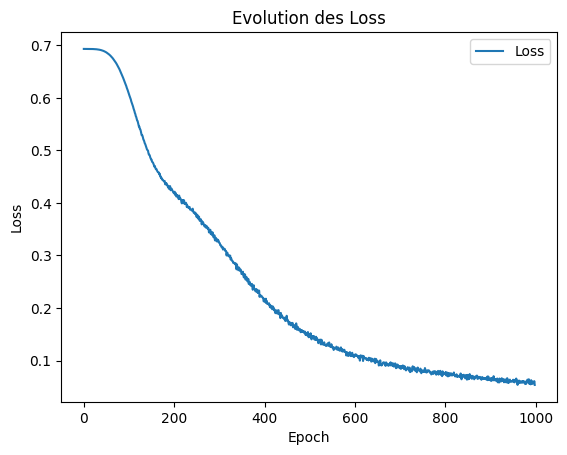

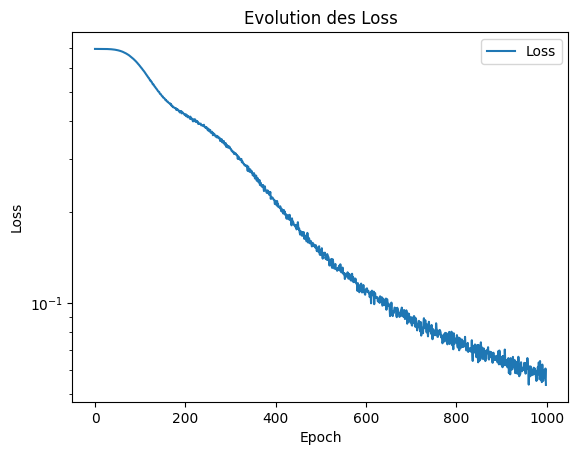

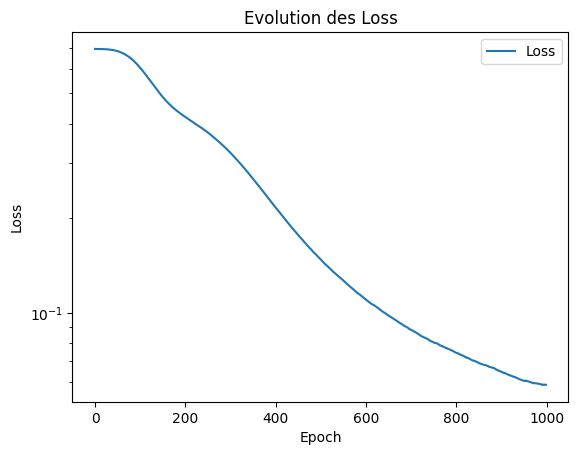

In [9]:
def plot_loss(loss_list):
    plt.plot(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_loss_log(loss_list):
    plt.semilogy(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def running_mean(list,
                 half_window: int # Number of elements that the function will consider
                                  # ahead and behind the position X to calculate running mean at X.
                 ):

    running_means = []

    for i in range(0,len(list)):

        left_bound = max(0,i-half_window)
        right_bound = min(len(list)-1, i + half_window)
        sublist = list[left_bound:right_bound+1]
        running_means.append(sum(sublist)/len(sublist))

    return running_means

plot_loss(losses)
plot_loss_log(losses)
plot_loss_log(running_mean(losses, 30))

In [10]:
complex_model.to(device)
torch.set_grad_enabled(False)

# Is complex_model coherent ?
iric_first_line = iric.iloc[0].tolist()
map_tail = entity_to_mapping[iric_first_line[0]]
map_head = entity_to_mapping[iric_first_line[2]]
map_rel = relation_to_mapping[iric_first_line[1]]

print("Good score should appear here :")
print(complex_model(torch.tensor(map_tail),torch.tensor(map_rel),torch.tensor(map_head)))



print("Bad scores should appear here :")
print(complex_model(torch.tensor(random.choice(list(mapping_to_entity.keys()))),torch.tensor(0),torch.tensor(random.choice(list(mapping_to_entity.keys())))))
print(complex_model(torch.tensor(random.choice(list(mapping_to_entity.keys()))),torch.tensor(0),torch.tensor(random.choice(list(mapping_to_entity.keys())))))

Good score should appear here :
tensor(4.0170)
Bad scores should appear here :
tensor(3.0481)
tensor(5.3012)


In [11]:
model_save_path = "TestComplEx"
loc_path = %pwd
torch.save(complex_model.state_dict(), model_save_path)
print(f'Model saved at {loc_path}/{model_save_path}')

Model saved at /home/elliot/Documents/ESL2024/code/TestComplEx


# Iniating model with Lin loss

In [12]:
nxo = from_file(url)
nxo.freeze()

In [13]:
possibles_tails: dict = {}
for index, row in iric.iterrows():
    head, rel, tail = row.iloc[0], row.iloc[1], row.iloc[2]
    hr = (head, rel)
    if hr not in possibles_tails:
        possibles_tails[hr]=[tail]
    else :
        possibles_tails[hr].append(tail)

print(possibles_tails)

{('OsNippo01g010050', 'gene ontology'): ['GO:0031267', 'GO:0006886', 'GO:0005622', 'GO:0005623', 'GO:0090630', 'GO:0043087', 'GO:0005096'], ('OsNippo01g010100', 'gene ontology'): ['GO:0020037', 'GO:0016705', 'GO:0055114', 'GO:0004497', 'GO:0005506', 'GO:0009055'], ('OsNippo01g010200', 'gene ontology'): ['GO:0055114', 'GO:0016722', 'GO:0005507', 'GO:0016491', 'GO:0005886', 'GO:0009506', 'GO:0046658'], ('OsNippo01g010300', 'gene ontology'): ['GO:0016020'], ('OsNippo01g010350', 'gene ontology'): ['GO:0003676'], ('OsNippo01g010400', 'gene ontology'): ['GO:0016020'], ('OsNippo01g010450', 'gene ontology'): ['GO:0006412', 'GO:0019843', 'GO:0005622', 'GO:0003723', 'GO:0042542', 'GO:0000028', 'GO:0022627', 'GO:0009651', 'GO:0003735', 'GO:0009414', 'GO:0009737', 'GO:0050832', 'GO:0003729', 'GO:0005840', 'GO:0015935'], ('OsNippo01g010550', 'gene ontology'): ['GO:0005783', 'GO:0016829', 'GO:0006888', 'GO:0051788', 'GO:0006629', 'GO:0016020', 'GO:0006635', 'GO:0043161', 'GO:0050832', 'GO:0009751', 

In [14]:
def lin_similarity(term1:str, term2:str, ontology, error_return = 0):
  '''
  Returns the highier lin similarity of two entities of a list of given ontologies.
  /!\ If calculation is impossible (for example if one of the entities is in none of the ontologies), return error_return (default 0).

  Parameters :
  - term1 (str): ID of the first entity as a string (example : "GO:0042552")
  - term2 (str): ID of the second entity as a string (example : "GO:0042552")
  - ontology (nxontology.ontology.NXOntology objects) : An ontology loaded with nxontology.
  - error_return : The output of the function if lin similarity cannot be calculated. Default 0.

  Returns :
  - linsim (float): The Lin similarity of the two entities in the ontology.
                    It is a a number in [0;1].
                    linsim(A,B) close of 0 means A and B are distant in the ontology ;
                    lisnsim(A,B) close of 1 means A and B are close entities in the ontology.
  '''
  try :
      return ontology.similarity(term1, term2).lin
  except :
      return error_return
  
def LinSim_errors_for_triple(triple: tuple,
                             ontology,
                             possibles_tails_for_head_rel_double:dict,
                             error_return = 0
                                              )-> list :
  '''
  Given a triple (head, relation, tail) and an ontology, calculates the list of LinSim between the real head of the triple and the expected heads for the (head, relation) couple.

  Parameters :
  - triple (tuple): (head: int, relation: int, tail: int)
  - ontology (nxontology.ontology.NXOntology) : An ontology loaded with nxontology.
  - possibles_tails_for_head_rel_double (dict): Associates the list of possible tails to a (head, relation) tuple.
  - error_return : The output of the function if lin similarity cannot be calculated. Default 0.

  Returns :
  - similarities (list) : the list of LinSim between the actual triple head and the possible heads of the triple found in iric.
  '''
  head, relation, tail = triple[0], triple[1], triple[2]

  possibles_tails = possibles_tails_for_head_rel_double[(head, relation)]
  similarities = [lin_similarity(tail, possible_tail, ontology=ontology, error_return=error_return) for possible_tail in possibles_tails]

  return similarities

def LinSim_errors_for_triples_in_tensors(triples: torch.tensor,
                                         ontology,
                                         possibles_tails_for_head_rel_double:dict,
                                         error_return = 0)-> list :
  '''
  Given tensor of triples of tensors (torch.tensor([heads]), torch.tensor([relations]), torch.tensor([tails])) and an ontology, calculates the list of LinSim between the real head of the triple and the expected heads for the (head, relation) couple.

  Parameters :
  - triples (tuple): (torch.tensor([heads]), torch.tensor([relations]), torch.tensor([tails])) : a 3-uple of three tensors which contains heads, relations and tails. each line of the concatanation of the three tensors represents a triple.
  - ontology (list of nxontology.ontology.NXOntology objects) : An ontology loaded with nxontology.
  - possibles_tails_for_head_rel_double (dict): Associates the list of possible tails
  - error_return : The output of the function if lin similarity cannot be calculated. Default 0.

  Returns :
  - similarities (list) : the list of LinSim between the actual triple head and the possible heads of the triple found in iric.
  '''

  heads, relations, tails = triples[0], triples[1], triples[2]

  all_similarities = []
  for i in range(len(heads)):
    head, relation, tail = heads[i].items(), relations[i].items(), tails[i].items()
    similarities = LinSim_errors_for_triple(triple = (head, relation, tail),
                                            ontology=ontology,
                                            possibles_tails_for_head_rel_double=possibles_tails_for_head_rel_double,
                                            error_return=error_return
                                            )
  all_similarities+=similarities

  return torch.tensor([sum(all_similarities)/len(all_similarities)])

In [15]:
class Lin_ComplEx(ComplEx):
  def loss(
        self,
        head_index: torch.Tensor,
        rel_type: torch.Tensor,
        tail_index: torch.Tensor,
    ) -> torch.Tensor:

        pos_score = self(head_index, rel_type, tail_index)
        neg_score = self(*self.random_sample(head_index, rel_type, tail_index))
        scores = torch.cat([pos_score, neg_score], dim=0)

        pos_target = torch.ones_like(pos_score)
        neg_target = torch.zeros_like(neg_score)
        target = torch.cat([pos_target, neg_target], dim=0)

        

        return F.binary_cross_entropy_with_logits(scores, target)-LinSim_errors_for_triple()


SyntaxError: invalid syntax (1479904636.py, line 17)